# On-premise, pre-trained embeddings from HF models

Goal: Understand how to extract an embedding from a pre-trained HF model. 

Related notebooks: In lecture 6, we saw an example of extracting embeddings with a dedicated embedding package `sentence-transformers`. Here, we illustrate how to extract some hidden layer of a normal model (e.g. for classification) and use it as ebmedding in downstream tasks. 

### Simple example

In [1]:
# Simple way to extract embeddings
# This uses an alternative to pipeline, which gives
# more control, as it allows to manipulate the model.

from transformers import ResNetModel, AutoImageProcessor
from PIL import Image

image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetModel.from_pretrained("microsoft/resnet-50")

IMAGE_PATH = "IMG_7595.jpeg"
image = Image.open(IMAGE_PATH)

inputs = image_processor(images=image, return_tensors="pt")
pixel_values = inputs['pixel_values']
outputs = model(pixel_values)

features = outputs.pooler_output.squeeze().detach().numpy()

/Users/joseantonio.rodriguez15/code/data-driven-prototypes/.venv/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


### Comparing embeddings

Let's create a function that computes the embedding given a file name. 

In [2]:
def get_embeddings(image_path):
    # Load the image
    image = Image.open(image_path)

    inputs = image_processor(images=image, return_tensors="pt")

    # Pass the pixel values through the model
    outputs = model(**inputs)

    # Extract the feature vector from the output
    features = outputs.pooler_output.squeeze().detach().numpy()

    return features


Now let's compare the embeddings of 3 images. The first 2 are of the same category. 

In [3]:

vec1 = get_embeddings("IMG_7595.jpeg")
vec2 = get_embeddings("IMG_7599.jpeg")
vec3 = get_embeddings("IMG_6861.jpeg")

Visualize the embeddings

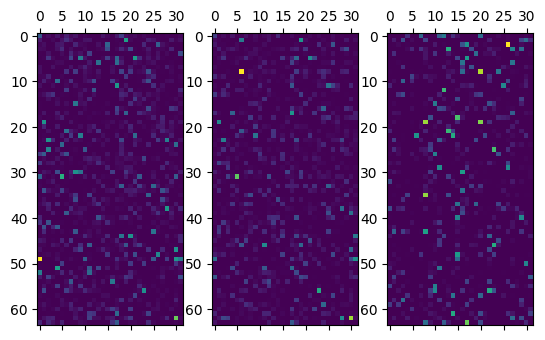

In [4]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 3)
ax[0].matshow(vec1.reshape(64, 32))
ax[1].matshow(vec2.reshape(64, 32))
ax[2].matshow(vec3.reshape(64, 32))


Visualize pairwise cosine similarities. 

In [5]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the cosine similarity between the vectors
similarity = cosine_similarity([vec1, vec2, vec3])

similarity

array([[1.0000002 , 0.6610931 , 0.2020809 ],
       [0.6610931 , 0.9999998 , 0.2073114 ],
       [0.2020809 , 0.2073114 , 0.99999976]], dtype=float32)

We can use those embeddings in downstream tasks. 

## Example "downstream task": image similarity

In [6]:
import os

DIR = # your directory here

# Loop over all images in DIR
embeddings = []
files = []
for image_path in os.listdir(DIR):
    # Skip non-image files
    if not image_path.endswith(".jpeg"):
        continue

    # Get the full path to the image
    full_path = os.path.join(DIR, image_path)
    files += [full_path]

    # Extract the embeddings
    embedding = get_embeddings(full_path)
    embeddings.append(embedding)

embeddings = np.array(embeddings)



In [7]:
# Compute cosine similarity between 8th image and all others
similarity = cosine_similarity(embeddings[8].reshape(1, -1), embeddings)

In [8]:
top_5 = similarity.argsort()[0][::-1][:5]
top_5

array([ 8, 12, 22, 19,  6])

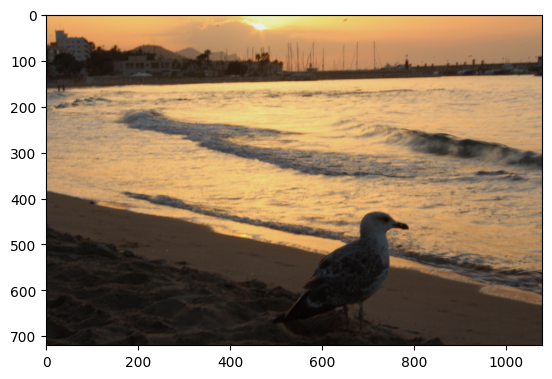

In [9]:
plt.imshow(Image.open(files[6]))